In [6]:
import drawsvg as dw
from os import listdir
dir = '/home/jh/src/svg/lib'
files = listdir(dir)
for file in files:
    if file[-3:] == '.py':
        f = '%s/%s' % (dir,file)
        exec(open(f).read())

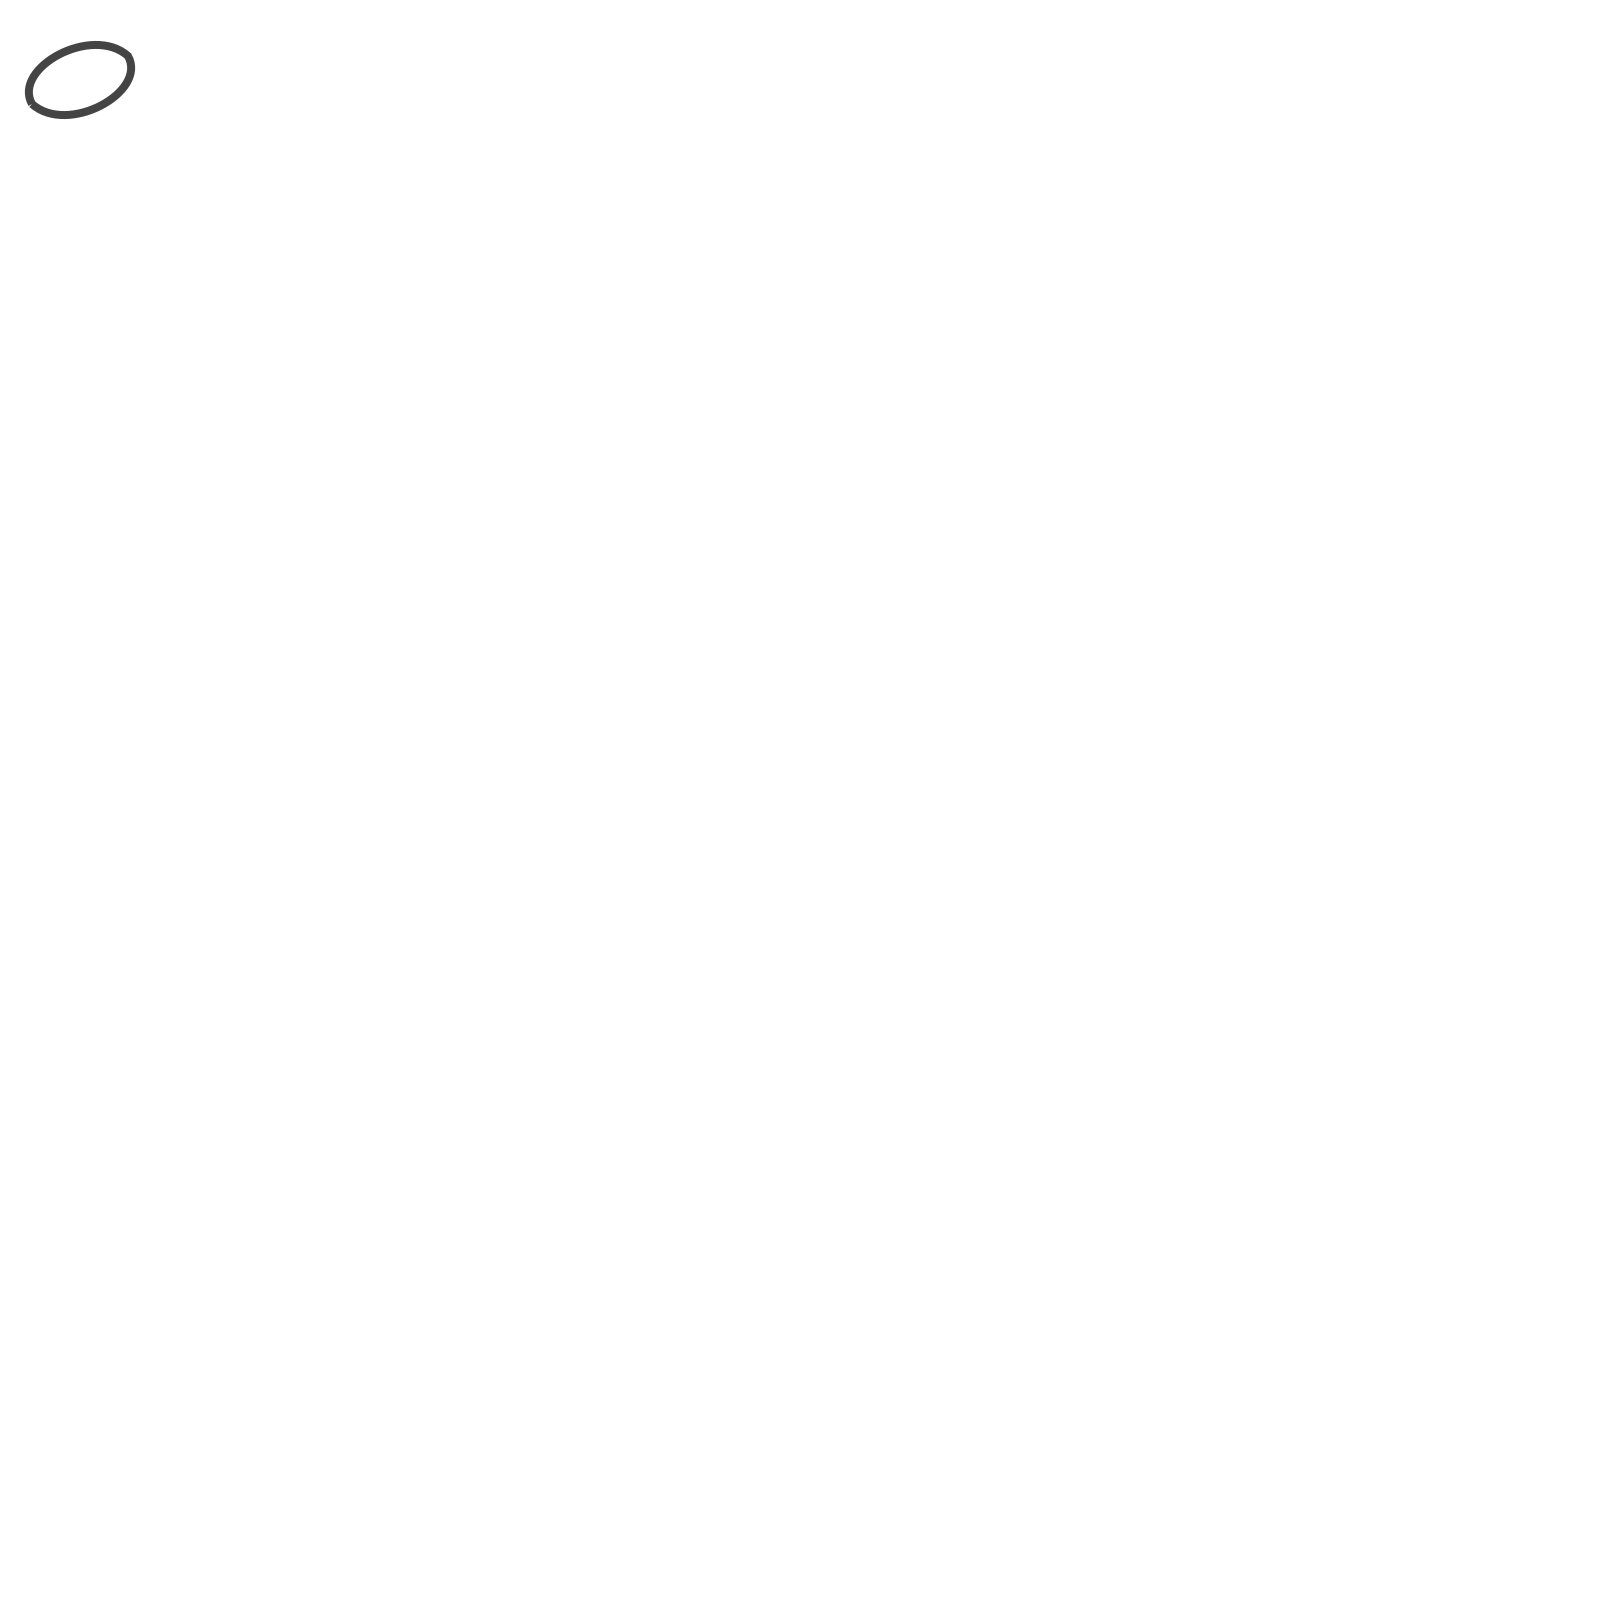

In [12]:
d = dw.Drawing(200,200)




note(fill='none')
d.set_pixel_scale(8)
#d.save_png('varVib.png')
#d.save_svg('varVib.svg')
d

In [4]:
help(tie)

Help on function tie in module __main__:

tie(x=10, y=10, xend=100, yend=10, dir=1, sw=1, c='black', thick=1, **args)
    tie (haltebogen) between two notes
    dir=1 means bowing downwards, dir=1 upwards
    larger number means more bowing
    thick results in the thickness

